# Data processing

Download, save, visualize and load dataset.



In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DATA_DIR = "../../data/"
resolution = "5.625deg"

## 1. geopotential_500, temperature_850

### The signal

- Test: years 2017 and 2018
- Validation: year 2016
- Train: year 2015

In [327]:
def load_data(path, train_years=slice('2015', '2015'), val_years=slice('2016', '2016'), 
              test_years=slice('2017', '2018')):
    """
    Args:
        path: Path to nc files
        var: variable. Geopotential = 'z', Temperature = 't'
        years: slice for time window
    Returns:
        dataset: Concatenated dataset for 2017 and 2018
    """
    zpath = path + 'geopotential_500'
    tpath = path + 'temperature_850'
    
    z = xr.open_mfdataset(zpath+'/*.nc', combine='by_coords')['z']
    t = xr.open_mfdataset(tpath+'/*.nc', combine='by_coords')['t']
    
    try:
        # z = z.sel(level=500).drop('level')
        #z = z.drop('level')
        z = z.assign_coords(level=1)
    except ValueError:
        pass

    try:
        # t = t.sel(level=850).drop('level')
        #t = t.drop('level')
        t = t.assign_coords(level=1)
    except ValueError:
        pass
    
    dataset = xr.merge([z, t])
    #dataset = xr.concat([z, t], 'level').transpose('time', 'lat', 'lon', 'level')
    
    return dataset.sel(time=train_years), dataset.sel(time=val_years), dataset.sel(time=test_years)
    

In [328]:
train, val, test = load_data(DATA_DIR + resolution + "/")
N = train.dims['lat']*train.dims['lon']

### Structure of the samples

Each element of each xarray sample is organized as: (Latitude_value, [longitude_list], [signal_value_list])

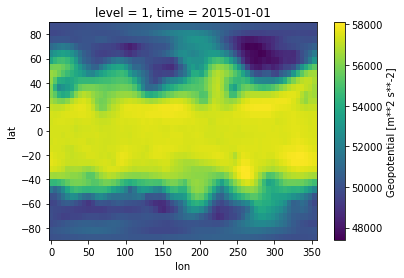

In [5]:
train.z[0].plot()

### The graphs

In order to use DeepSphere convolutional kernels, the input samples need to be:
- A 1d vector with the signal
- the Graph Laplacian 

/!\ Correspondence of the vertices
-> We used 'SOFT' sampling, an improved version of the Driscoll-Heally sampling that does not include the poles in order to fit the signal data

1. Sample the vertices  
    1.1. Create weight matrix  
    1.2. Get the indexes corresponding to the sampled vectors (for the signal)  
    
2. Order the vertices in a 1D vector (torch tensor)
3. Compute the Laplacian (torch tensor)

TO DO:
- Rasterizing method?

In [309]:
import pygsp
from pygsp import plotting
from pygsp.graphs.sphereequiangular import SphereEquiangular

In [310]:
graph = SphereEquiangular(bandwidth=(16, 32), sampling='SOFT')

print('MSE between graph and signal vertex latitudes:', sum((train.z[0].lat.values - graph.lat[:, 0] * (180/np.pi))**2))
print('MSE between graph and signal vertex longitudes:', sum((train.z[0].lon.values - graph.lon[0] * (180/np.pi))**2))
    

MSE between graph and signal vertex latitudes: 9.533384039595928e-28
MSE between graph and signal vertex longitudes: 1.868022623563356e-27


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7ff36441b9d0>)

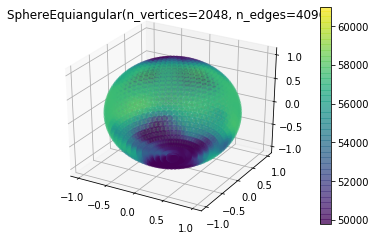

In [10]:
graph.plot_signal(train.z[0].values.reshape((32*64, 1)), vertex_size=50)

In [317]:
from deepsphere.utils.laplacian_funcs import prepare_laplacian
from deepsphere.utils.samplings import equiangular_dimension_unpack

def get_equiangular_laplacians2(nodes, ratio, depth, laplacian_type, pool_size):
    """Get the equiangular laplacian list for a certain depth.
    Args:
        nodes (tuple): input signal size (lat x lon)
        depth (int): the depth of the UNet.
        laplacian_type ["combinatorial", "normalized"]: the type of the laplacian.
        pool_size: size of the pooling kernel
    Returns:
        laps (list): increasing list of laplacians
    """
    laps = []
    dim1, dim2 = equiangular_dimension_unpack(nodes, ratio)
    
    for i in range(depth):
        # Adjust dimensions with depth!
        bw1 = int(dim1/(2*pool_size**i))
        bw2 =int(dim2/(2*pool_size**i))
        bw = [bw1, bw2]
        
        G = SphereEquiangular(bandwidth=bw, sampling="SOFT")
        G.compute_laplacian(laplacian_type)
        laplacian = prepare_laplacian(G.L)
        laps.append(laplacian)
    return laps

### Data generator

This data generator needs to provide:
- normalized data 
- in correct shape
- consisting in samples and labels
- as a torch tensor


In [11]:
from torch.utils.data import Dataset

In [227]:
import time

In [249]:
class WeatherBenchDataset(Dataset):
    
    def __init__(self, data, delta_t, mean=None, std=None):
        
        data = [data[var] for var in data.data_vars]
        data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        
        self.data = data
        self.delta_t = delta_t
        
        # Normalize
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
        self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        self.data = (self.data - self.mean) / self.std
        
        '''data = [data[var] for var in ['z', 't']]
        data = xr.concat(data, 'level')
        data = data.stack(v=('lat', 'lon')).transpose('time', 'v', 'level')
        
        self.data = data
        self.delta_t = delta_t
        
        # Normalize
        self.mean = self.data.mean(('time', 'v')).compute() if mean is None else mean
        self.std = self.data.std('time').mean(('v')).compute() if std is None else std
        self.data = (self.data - self.mean) / self.std'''
        
        # Number of samples
        self.n_samples = self.data.isel(time=slice(0, -delta_t)).shape[0]
        self.N = self.data.shape[1]*self.data.shape[2]
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        """ Returns sample and label corresponding to an index as torch.Tensor objects
            The return tensor shapes are (for the sample and the label): [n_vertex, n_features]
        """
        
        X = self.data.isel(time=idx).values
        X = torch.Tensor(X).reshape((self.N, -1))
        y = self.data.isel(time=idx+self.delta_t).values
        y = torch.Tensor(y).reshape((self.N, -1))
        
        return X, y

### The models

https://github.com/ArcaniteSolutions/deepsphere

In [286]:
from torch import nn

from deepsphere.models.spherical_unet.encoder import SphericalChebBN2
from deepsphere.models.spherical_unet.utils import SphericalChebBNPool
from deepsphere.models.spherical_unet.decoder import SphericalChebBNPoolConcat, SphericalChebBNPoolCheb


from deepsphere.layers.chebyshev import SphericalChebConv
from deepsphere.utils.laplacian_funcs import get_equiangular_laplacians
from deepsphere.layers.samplings.equiangular_pool_unpool import Equiangular, reformat
from deepsphere.utils.samplings import equiangular_calculator
import torch.nn.functional as F

In [284]:
class EquiangularMaxPool2(nn.MaxPool1d):
    """EquiAngular Maxpooling module using MaxPool 1d from torch
    """

    def __init__(self, ratio, kernel_size, return_indices=False):
        """Initialization
        Args:
            ratio (float): ratio between latitude and longitude dimensions of the data
        """
        self.ratio = ratio
        super().__init__(kernel_size=kernel_size, return_indices=return_indices)

    def forward(self, x):
        """calls Maxpool1d and if desired, keeps indices of the pixels pooled to unpool them
        Args:
            input (:obj:`torch.tensor`): batch x pixels x features
        Returns:
            tuple(:obj:`torch.tensor`, list(int)): batch x pooled pixels x features and the indices of the pixels pooled
        """
        x, _ = equiangular_calculator(x, self.ratio)
        x = x.permute(0, 3, 1, 2)

        if self.return_indices:
            x, indices = F.max_pool2d(x, self.kernel_size, return_indices=self.return_indices)
        else:
            x = F.max_pool2d(x, self.kernel_size)
        x = reformat(x)

        if self.return_indices:
            output = x, indices
        else:
            output = x

        return output


class EquiangularMaxUnpool2(nn.MaxUnpool1d):
    """Equiangular Maxunpooling using the MaxUnpool1d of pytorch
    """

    def __init__(self, ratio, kernel_size):
        """Initialization
        Args:
            ratio (float): ratio between latitude and longitude dimensions of the data
        """
        self.ratio = ratio
        super().__init__(kernel_size=kernel_size)

    def forward(self, x, indices):
        """calls MaxUnpool1d using the indices returned previously by EquiAngMaxPool
        Args:
            x (:obj:`torch.tensor`): batch x pixels x features
            indices (int): indices of pixels equiangular maxpooled previously
        Returns:
            :obj:`torch.tensor`: batch x unpooled pixels x features
        """
        x, _ = equiangular_calculator(x, self.ratio)
        x = x.permute(0, 3, 1, 2)
        x = F.max_unpool2d(x, indices, kernel_size=(self.kernel_size, self.kernel_size))
        x = reformat(x)
        return x

In [318]:
laplacians_test = get_equiangular_laplacians2(N, ratio, 3, 'combinatorial', 2)

In [297]:
max_pool_test = EquiangularMaxPool(ratio, 2)
max_unpool_test = EquiangularMaxUnpool(ratio, 2)

conv_test = SphericalChebConv(2, 64, laplacians_test[2], 5)


test_sample = training_set[2][0].unsqueeze(0)

0.8580038547515869
0.0001342296600341797
0.6907894611358643
0.00011730194091796875


In [333]:
class Encoder2(nn.Module):
    """
    SphericalChebConv has "same" padding
    
    """
    def __init__(self, channels_in, kernel_size, ratio, laplacians, pool_size, pooling="max"):
    
        super().__init__()

        self.kernel_size = kernel_size

        self.conv1 = SphericalChebConv(channels_in, 64, laplacians[0], self.kernel_size)
        self.conv2 = SphericalChebConv(64, 128, laplacians[1], self.kernel_size)
        self.conv3 = SphericalChebConv(128, 256, laplacians[2], self.kernel_size)

        self.pool = EquiangularMaxPool2(ratio, pool_size)
        

    def forward(self, x):
        """Forward Pass.
        Args:
            x (:obj:`torch.Tensor`): input [batch x vertices x channels/features]
        Returns:
            x_enc* :obj: `torch.Tensor`: output [batch x vertices x channels/features]
        """
        x_enc1 = self.conv1(x)
        x_enc2 = self.conv2(self.pool(x_enc1))
        x_enc3 = self.conv3(self.pool(x_enc2))

        return x_enc2, x_enc3

class Decoder2(nn.Module):
    """The decoder of the Spherical UNet.
    """
    
    def __init__(self, channels_out, kernel_size, ratio, laplacians, pool_size, pooling="max"):
        """Initialization.
        Args:
            unpooling (:obj:`torch.nn.Module`): The unpooling object.
            laps (list): List of laplacians.
        """
        super().__init__()
        self.kernel_size = kernel_size
        
        self.unpool = EquiangularMaxUnpool(ratio, pool_size)

        self.conv3 = SphericalChebConv(256, 128, laplacians[2], self.kernel_size)
        self.conv2 = SphericalChebConv(128, 64, laplacians[1], self.kernel_size)
        self.conv1 = SphericalChebConv(64, channels_out, laplacians[0], self.kernel_size)

        # Switch from Logits to Probabilities if evaluating model
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x_enc3, x_enc2):
        """Forward Pass.
        Args:
            x_enc* (:obj:`torch.Tensor`): input tensors.
        Returns:
            :obj:`torch.Tensor`: output after forward pass.
        """
        
        x = self.unpool(self.conv3(x_enc3))
        x = torch.cat(x, x_enc2)
        x = self.unpool(self.conv2(x))
        x = self.conv1(x)
        
        if not self.training:
            x = self.softmax(x)
        return x
    
class SphericalUNet2(nn.Module):
    """Spherical GCNN Autoencoder.
    """

    def __init__(self, nodes, ratio, depth, channels_in, channels_out, laplacian_type, kernel_size, pooling_size, 
                 pooling="max"):
        """Initialization.
        Args:
            N (int): Number of pixels in the input image
            depth (int): The depth of the UNet, which is bounded by the N and the type of pooling
            kernel_size (int): chebychev polynomial degree
            ratio (float): Parameter for equiangular sampling -> width/height
        """
        super().__init__()
        self.kernel_size = kernel_size
        
        self.pooling_class = Equiangular(mode=pooling)
        self.laplacians = get_equiangular_laplacians2(nodes, ratio, depth, laplacian_type, pooling_size)

        self.encoder = Encoder2(channels_in, self.kernel_size, ratio, self.laplacians, pooling_size, pooling)
        self.decoder = Decoder2(channels_out, self.kernel_size, ratio, self.laplacians, pooling_size, pooling)

    def forward(self, x):
        """Forward Pass.
        Args:
            x (:obj:`torch.Tensor`): input to be forwarded.
        Returns:
            :obj:`torch.Tensor`: output
        """
        x_encoder = self.encoder(x)
        output = self.decoder(*x_encoder)
        return output

In [45]:
class Encoder(nn.Module):
    """Encoder for the Spherical UNet.
    """

    def __init__(self, channels_in, kernel_size, pooling, laplacians):
        """Initialization.
        Args:
            pooling (:obj:`torch.nn.Module`): pooling layer.
            laps (list): List of laplacians.
            kernel_size (int): polynomial degree.
        """
        super().__init__()
        self.depth = len(laps)//2 + 1
        self.pooling = pooling
        self.kernel_size = kernel_size
        
        self.enc_l5 = SphericalChebBN2(channels_in, 32, 64, laplacians[2], self.kernel_size)
        self.enc_l4 = SphericalChebBNPool(64, 128, laplacians[1], self.pooling, self.kernel_size)
        self.enc_l3 = SphericalChebBNPool(128, 256, laplacians[0], self.pooling, self.kernel_size)
        

    def forward(self, x):
        """Forward Pass.
        Args:
            x (:obj:`torch.Tensor`): input [batch x vertices x channels/features]
        Returns:
            x_enc* :obj: `torch.Tensor`: output [batch x vertices x channels/features]
        """
        x_enc5 = self.enc_l5(x)
        x_enc4 = self.enc_l4(x_enc5)
        x_enc3 = self.enc_l3(x_enc4)

        return x_enc3, x_enc4

class Decoder(nn.Module):
    """The decoder of the Spherical UNet.
    """

    def __init__(self, channels_out, kernel_size, unpooling, laplacians):
        """Initialization.
        Args:
            unpooling (:obj:`torch.nn.Module`): The unpooling object.
            laps (list): List of laplacians.
        """
        super().__init__()
        self.unpooling = unpooling
        self.kernel_size = kernel_size

        self.dec_l3 = SphericalChebBNPoolConcat(256, 128, laplacians[0], self.unpooling, self.kernel_size)
        self.dec_l4 = SphericalChebBNPoolConcat(128, 64, laplacians[1], self.unpooling, self.kernel_size)
        self.dec_l5 = SphericalChebBNPoolCheb(64, 32, channels_out, laplacians[2], self.unpooling, 
                                              self.kernel_size)
        # Switch from Logits to Probabilities if evaluating model
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x_enc3, x_enc4):
        """Forward Pass.
        Args:
            x_enc* (:obj:`torch.Tensor`): input tensors.
        Returns:
            :obj:`torch.Tensor`: output after forward pass.
        """
        x = self.dec_l3(x, x_enc3)
        x = self.dec_l4(x, x_enc4)
        x = self.dec_l5(x)
        if not self.training:
            x = self.softmax(x)
        return x

class SphericalUNet(nn.Module):
    """Spherical GCNN Autoencoder.
    """

    def __init__(self, N, depth, channels_in, channels_out, laplacian_type, kernel_size, ratio, pooling):
        """Initialization.
        Args:
            N (int): Number of pixels in the input image
            depth (int): The depth of the UNet, which is bounded by the N and the type of pooling
            kernel_size (int): chebychev polynomial degree
            ratio (float): Parameter for equiangular sampling -> width/height
        """
        super().__init__()
        self.ratio = ratio
        self.kernel_size = kernel_size
        
        self.pooling_class = Equiangular(mode=pooling)
        self.laplacians = get_equiangular_laplacians(N, depth, self.ratio, laplacian_type)

        self.encoder = Encoder(channels_in, self.kernel_size, self.pooling_class.pooling, self.laplacians)
        self.decoder = Decoder(channels_out, self.kernel_size, self.pooling_class.unpooling, self.laplacians)

    def forward(self, x):
        """Forward Pass.
        Args:
            x (:obj:`torch.Tensor`): input to be forwarded.
        Returns:
            :obj:`torch.Tensor`: output
        """
        x_encoder = self.encoder(x)
        output = self.decoder(*x_encoder)
        return output

### Train 

In [19]:
import torch

from torch.utils.data import DataLoader
from torch import nn, optim 

In [93]:
def train_model(model, lr, device, train_generator, val_generator, patience):
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    min_val_loss = float("inf")
    epoch_no_improve = 0
    
    
    for epoch in range(n_epochs):
        val_loss = 0
        loss = 0
        
        model.train()
        for batch, labels in train_generator:
            # Transfer to GPU
            print('c')
            
            batch, labels = batch.to(device), labels.to(device)
            
            print('d')
            
            # Model
            output = model(data)
            
            print('e')
            '''B, V, C = output.shape
            B_labels, V_labels, C_labels = labels.shape

            output = output.view(B * V, C)
            labels = labels.view(B_labels * V_labels, C_labels).max(1)[1]'''

            loss = criterion(output, labels)
            print(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
        model.eval()
        with torch.set_grad_enabled(False):
            for batch, labels in val_generator:
                # Transfer to GPU
                batch, labels = batch.to(device), labels.to(device)
                
                output = model(data)
                '''B, V, C = output.shape
                B_labels, V_labels, C_labels = labels.shape

                output = output.view(B * V, C)
                labels = labels.view(B_labels * V_labels, C_labels).max(1)[1]'''

                val_loss += criterion(output, labels)/len(train_generator)
                
        # Print stuff
        print('Epoch: {e:3d}/{n_e:3d}  - loss: {l:.3f}  - val_loss: {v_l:.3f}'.format(e=epoch, n_e=n_epochs, 
                                                                                      l=loss, v_l=val_loss))
                
        # Check for early stopping
        if val_loss < min_val_loss:
            epoch_no_improve = 0
            min_val_loss = val_loss
        else:
            epoch_no_improve += 1

        if epoch_no_improve == patience:
            print('Epoch {e:3d}: early stopping'.format(e=epoch))
            torch.save(model.state_dict(), 'model.pt')
            break
            
    torch.save(model.state_dict(), 'model.pt')

In [95]:
def init_device(model, ids=None):
    """Initialize device based on cpu/gpu and number of gpu
    Args:
        device (str): cpu or gpu
        ids (list of int or str): list of gpus that should be used
        unet (torch.Module): the model to place on the device(s)
    Raises:
        Exception: There is an error in configuring the cpu or gpu
    Returns:
        torch.Module, torch.device: the model placed on device, the device
    """
    
    if torch.cuda.is_available():
        if ids is None:
            device = torch.device("cuda")
            model = model.to(device)
            unet = nn.DataParallel(unet)
        elif len(ids) == 1:
            device = torch.device("cuda:{}".format(ids[0]))
            model = model.to(device)
        else:
            device = torch.device("cuda:{}".format(ids[0]))
            model = model.to(device)
            model = nn.DataParallel(model, device_ids=[int(i) for i in ids])
    else:
        device = torch.device("cpu")
        model = model.to(device)

    return model, device

In [207]:
def mean_std(dataset):
    
    data = [dataset[var] for var in dataset.data_vars]
    data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')

    # Normalize
    mean = data.mean(('time', 'lat', 'lon')).compute()
    std = data.std('time').mean(('lat', 'lon')).compute()
    
    return mean, std

In [208]:
# Data
delta_t = 3*24
ratio = train.dims['lon']/train.dims['lat']
batch_size = 32

mean_train, std_train = mean_std(train)

In [307]:
training_set = WeatherBenchDataset(train, delta_t, mean_train, std_train)
validation_set = WeatherBenchDataset(val, delta_t, mean_train, std_train)

dataloader_train = DataLoader(training_set, batch_size=batch_size, shuffle=False, num_workers=8)
dataloader_validation = DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=8)

In [26]:
from deepsphere.layers.samplings.equiangular_pool_unpool import EquiangularMaxPool, EquiangularMaxUnpool

laps = get_equiangular_laplacians(N, 1, ratio, 'combinatorial')

pooling_layer_test = EquiangularMaxPool(ratio, return_indices=True)
unpooling_layer_test = EquiangularMaxUnpool(ratio)

test_sample = training_set[2][0].unsqueeze(0)

blob = pooling_layer_test.forward(test_sample)
blab = unpooling_layer_test.forward(blob[0], blob[1])

print('Recovery of the original shape:', test_sample.shape == blab.shape)

Recovery of the original shape: True


In [334]:
# Model 

learning_rate = 1e-4
n_epochs = 20

unet = SphericalUNet2(nodes=N, depth=3, channels_in=2, channels_out=2, laplacian_type='combinatorial', 
                     kernel_size=5, ratio=ratio, pooling_size = 2, pooling='max')

#unet, device = init_device(model=unet, ids=[0, 1])
unet, device = init_device(model=unet, ids=[0, 1])

In [324]:
train_model(unet, learning_rate, device, dataloader_train, dataloader_validation, patience=2)

KeyboardInterrupt: 

In [329]:
mean_test, std_test = mean_std(test)

In [336]:
testing_set[0]

(tensor([[-3.0028, -3.0722],
         [-2.9815, -3.0570],
         [-2.9602, -3.0550],
         ...,
         [-2.8183, -4.1095],
         [-2.8041, -4.0634],
         [-2.7899, -4.0383]]),
 tensor([[-2.4919, -2.9414],
         [-2.4848, -2.8858],
         [-2.4848, -2.8924],
         ...,
         [-4.6280, -4.7964],
         [-4.6280, -4.7718],
         [-4.6280, -4.7606]]))

In [338]:
batch.shape

torch.Size([1, 2048, 2])

In [335]:
testing_set = WeatherBenchDataset(test, delta_t, mean_test, std_test)
#dataloader_test = DataLoader(testing_set, batch_size=1, shuffle=False)

'''trained_unet = SphericalUnet(N=N, depth=3, channels_in=2, channels_out=2, laplacian_type='combinatorial', 
                     kernel_size=5, ratio=ratio, pooling='max')
trained_unet.load_state_dict(torch.load('model.pt'))
trained_unet.eval()'''


RMSE = 0
evaluation = nn.MSELoss()

for batch_idx, (batch, labels) in enumerate(testing_set):
    batch, labels = batch.unsqueeze(0), labels.unsqueeze(0)
    batch, labels = batch.to(device), labels.to(device)
                
    output = unet(batch)
    
    RMSE += evaluation(output, label)

RMSE = np.sqrt(RMSE/len(testing_set))

RuntimeError: shape '[512, 256]' is invalid for input of size 65536